In [10]:
import pandas as pd
from collections import defaultdict

# Function to get unique pairs from a list of characters
def get_unique_pairs(characters):
    pairs = set()
    for i in range(len(characters)):
        for j in range(i + 1, len(characters)):
            pairs.add(tuple(sorted([characters[i], characters[j]])))
    return pairs

# Load the CSV file into a DataFrame
file_path = 'Game_of_Thrones_Script.csv'
got_df = pd.read_csv(file_path)

# Remove rows where 'Name' is NaN
got_df_cleaned = got_df.dropna(subset=['Name'])

# Preparing a dictionary to hold interactions per season
interactions_per_season = defaultdict(lambda: defaultdict(int))

for i in range(len(got_df_cleaned)):
    current_season = got_df_cleaned.iloc[i]['Season']
    current_speaker = got_df_cleaned.iloc[i]['Name']

    # Next 5 lines or to the end of the dataset
    next_lines = got_df_cleaned.iloc[i+1:i+6]

    # Characters in the current conversation excluding the current speaker
    characters_in_conversation = list(next_lines['Name'].unique())
    if current_speaker in characters_in_conversation:
        characters_in_conversation.remove(current_speaker)

    # Get all unique pairs of characters in this conversation
    pairs = get_unique_pairs(characters_in_conversation)

    # Update the interaction count for each pair
    for pair in pairs:
        interactions_per_season[current_season][pair] += 1

# Convert to DataFrame for easier analysis and visualization
interactions_df = pd.DataFrame([
    {'Season': season, 'Pair': pair, 'Interactions': count}
    for season, pairs in interactions_per_season.items()
    for pair, count in pairs.items()
])

# Displaying a sample of the final DataFrame
interactions_df.sample(10)


,Season,Pair,Interactions
5159,Season 8,"(podrick, tyrion lannister)",2
2891,Season 4,"(jon snow, stannis baratheon)",5
1654,Season 3,"(jon snow, rattleshirt)",3
1494,Season 2,"(joffrey lannister, stannis baratheon)",2
1495,Season 2,"(davos, joffrey lannister)",5
3859,Season 5,"(brother, olly)",3
5303,Season 8,"(edmure, tyrion lannister)",7
520,Season 1,"(greatjon umber, theon greyjoy)",9
2931,Season 4,"(man, oberyn martell)",1
5073,Season 8,"(jaime lannister, tormund)",11


In [11]:
# Filtering the dataframe for Season 1 and sorting by the number of interactions
season_1_interactions = interactions_df[interactions_df['Season'] == 'Season 1']
top_15_interactions_season_1 = season_1_interactions.sort_values(by='Interactions', ascending=False).head(15)

top_15_interactions_season_1


,Season,Pair,Interactions
107,Season 1,"(daenerys targaryen, jorah mormont)",49
66,Season 1,"(eddard stark, robert baratheon)",45
22,Season 1,"(catelyn stark, robb stark)",40
48,Season 1,"(cersei lannister, eddard stark)",39
297,Season 1,"(bronn, tyrion lannister)",37
25,Season 1,"(catelyn stark, eddard stark)",36
21,Season 1,"(eddard stark, sansa stark)",35
63,Season 1,"(arya stark, eddard stark)",35
33,Season 1,"(robb stark, theon greyjoy)",30
68,Season 1,"(arya stark, sansa stark)",30


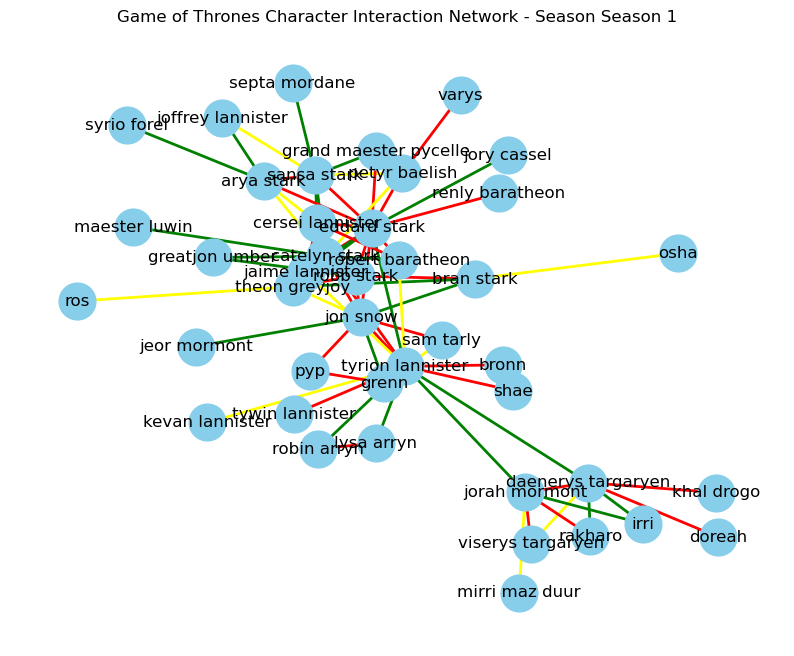

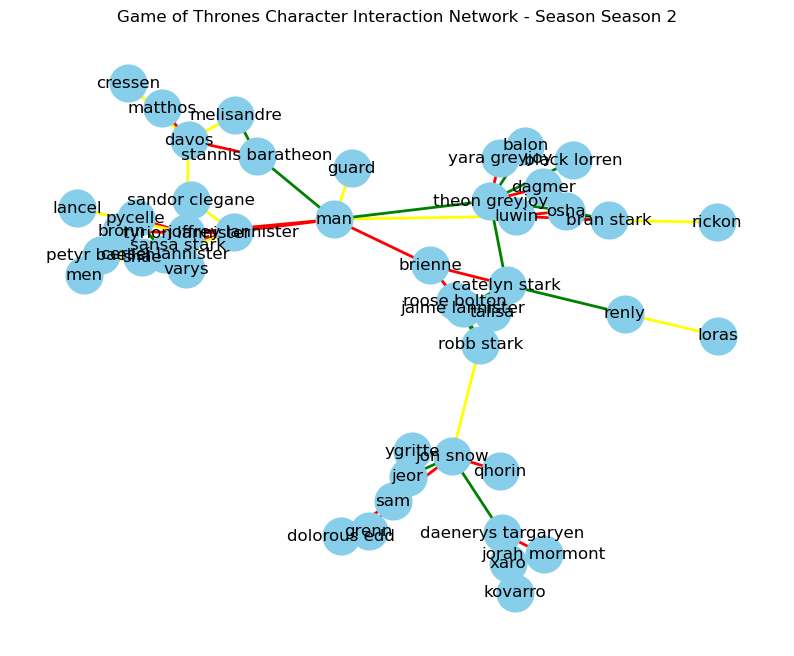

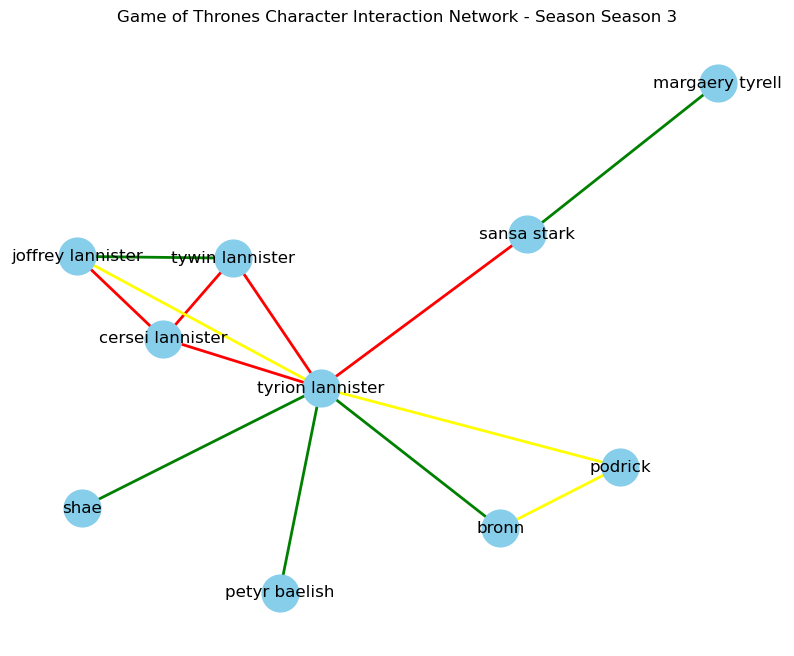

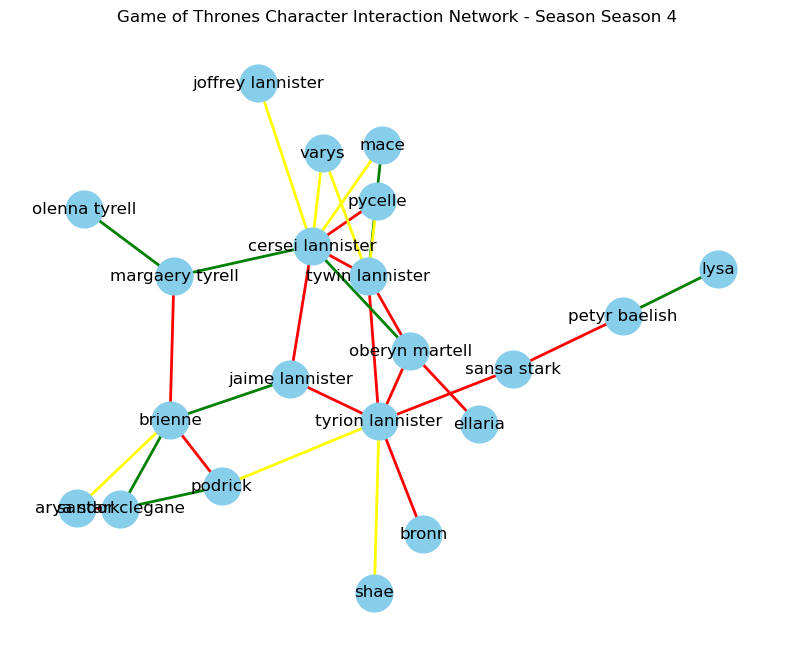

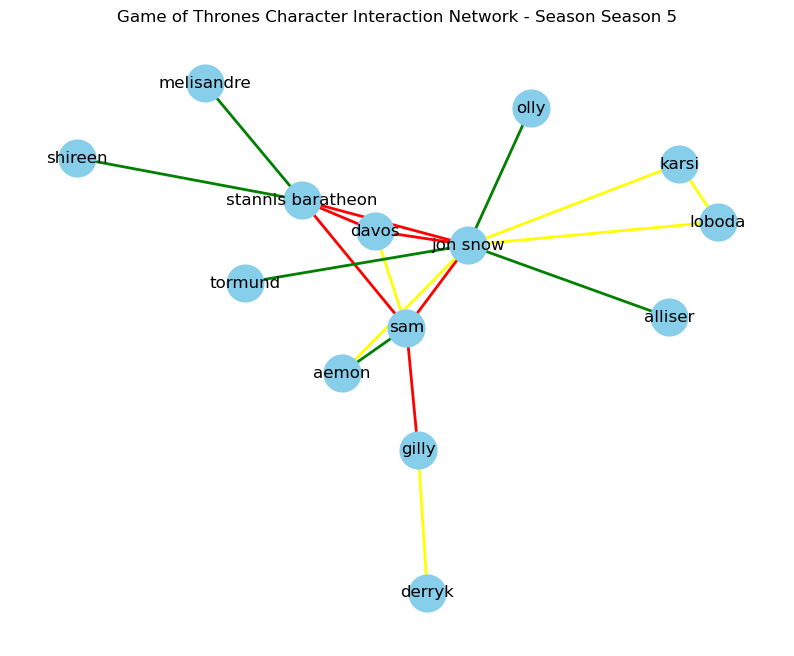

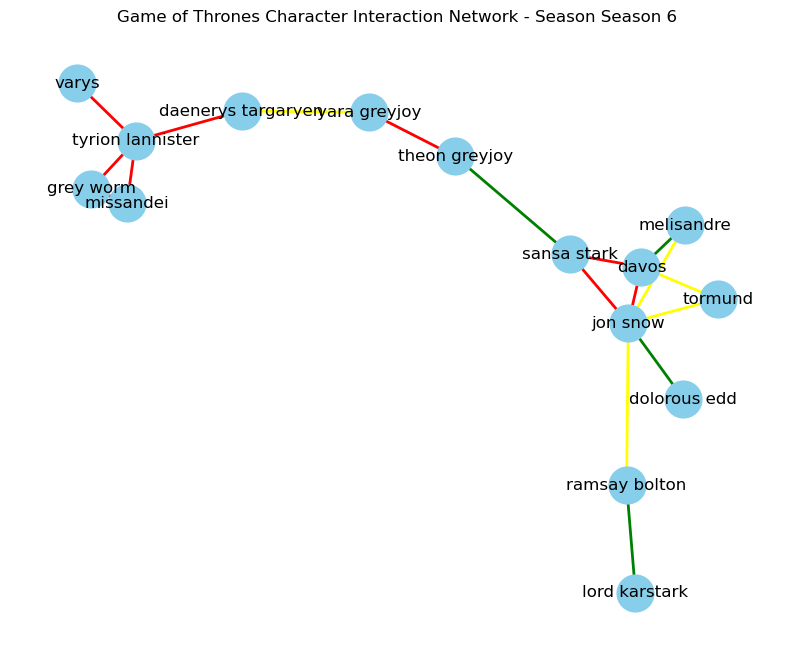

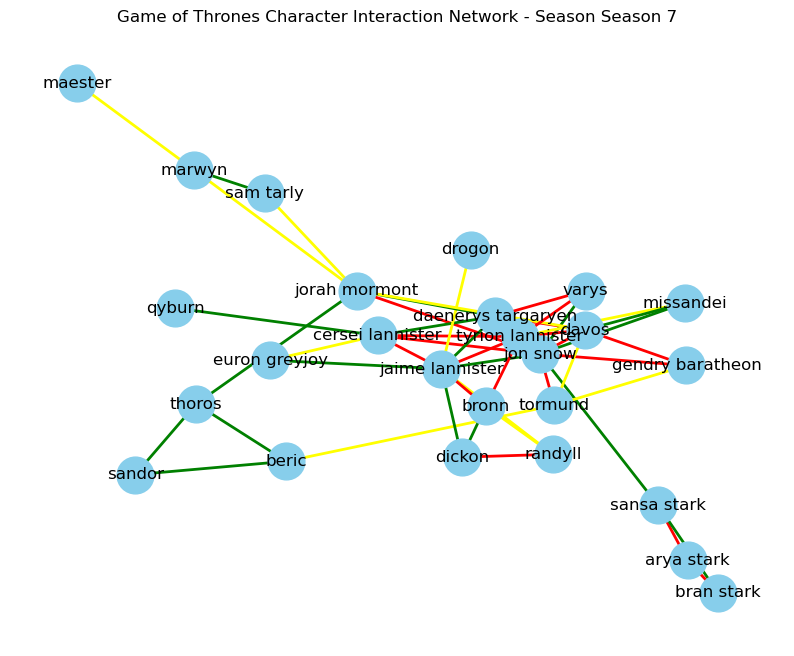

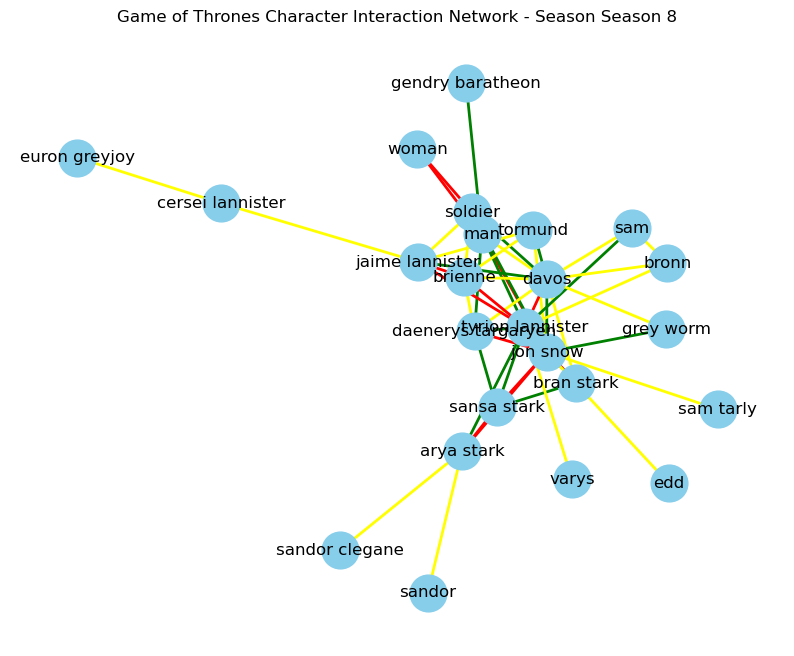

In [48]:
import matplotlib.pyplot as plt
import networkx as nx

# Create networks for each season
def create_network(season):
    # Filter data for the specific season
    season_data = interactions_df[interactions_df['Season'] == season]

    # Create a graph
    G = nx.Graph()
    
    # Add edges with interaction counts as weights, only if weight is 3 or more
    for index, row in season_data.iterrows():
        pair = row['Pair']
        interactions = row['Interactions']
        if interactions >= 10:
            G.add_edge(pair[0], pair[1], weight=interactions)

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    # Get the largest weakly connected component
    if len(G) > 0:  # Checking if the graph is not empty
        largest_component = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_component).copy()

    return G

# Plotting function
def plot_network(G, season):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes

    # Draw the nodes and the edges
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

    # Edges
    edge_colors = [
        'yellow' if G[u][v]['weight'] < 12 else
        'green' if 3 <= G[u][v]['weight'] <= 15 else
        'red' for u, v in G.edges()
    ]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title(f"Game of Thrones Character Interaction Network - Season {season}")
    plt.axis('off')
    plt.show()

# Plotting networks for each season
for season in sorted(interactions_df['Season'].unique()):
    G = create_network(season)
    plot_network(G, season)

In [56]:
import dash
from dash import dcc, html, Input, Output, State
import plotly.graph_objs as go
import networkx as nx
import pandas as pd

# Load and prepare your data here...
# Example: interactions_df = pd.read_csv('path_to_your_data.csv')

def create_plotly_graph(G, season):
    pos = nx.circular_layout(G)  # Using circular layout
    
    edge_trace = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = G[edge[0]][edge[1]]['weight']
        edge_color = 'yellow' if weight < 12 else 'green' if 12 <= weight <= 15 else 'red'
        
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=2, color=edge_color),
            hoverinfo='none',
            mode='lines'))

    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=[node for node in G.nodes()],
        mode='markers',
        customdata=[node for node in G.nodes()],
        hoverinfo='text',
        marker=dict(showscale=False, color='blue', size=10))

    return {
        'data': edge_trace + [node_trace],
        'layout': go.Layout(
            title=f'Game of Thrones Character Interaction Network - Season {season}',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            height=600
        )
    }

# Function to filter the graph based on the selected node
def filter_graph(G, node):
    neighbors = list(G.neighbors(node))
    return G.subgraph([node] + neighbors)

# Creating a Dash application
app = dash.Dash(__name__)

# App layout
app.layout = html.Div([
    dcc.Dropdown(
        id='season-dropdown',
        options=[{'label': f'Season {i}', 'value': i} for i in sorted(interactions_df['Season'].unique())],
        value=1
    ),
    html.Button('Reset', id='reset-button', n_clicks=0),
    dcc.Graph(id='network-graph', clickData=None, selectedData=None),
    html.Div(id='click-state', style={'display': 'none'})
])

# Callback to update graph based on season selection, node click, and reset button
@app.callback(
    Output('network-graph', 'figure'),
    Output('click-state', 'children'),
    [Input('season-dropdown', 'value'),
     Input('network-graph', 'clickData'),
     Input('reset-button', 'n_clicks')],
    [State('click-state', 'children')]
)
def update_graph(selected_season, clickData, reset_clicks, click_state):
    G = create_network(selected_season)
    ctx = dash.callback_context

    # Identify which input triggered the callback
    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'reset-button':
        new_click_state = None
    else:
        if clickData and 'customdata' in clickData['points'][0]:
            clicked_node = clickData['points'][0]['customdata']
            if clicked_node == click_state:
                new_click_state = None
            else:
                new_click_state = clicked_node
                G = filter_graph(G, new_click_state)
        else:
            new_click_state = click_state

    return create_plotly_graph(G, selected_season), new_click_state

# Running the app
if __name__ == '__main__':
    app.run_server(debug=True)
